In [1]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots

In [4]:
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# original data + previous supplemental sampling

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_01.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_02.npy", allow_pickle=True)
)

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
# sb_trajs = []
for i in range(6):
    sb_trajs.extend(
        np.load(f"../../data/raw_feat/feat2_suppl_{i:02d}.npy", allow_pickle=True)
    )

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3729000, 2) (3729000, 60)


In [9]:
traj_files = np.loadtxt("../../data/suppl_traj_files.txt", dtype=str)

# PMF

In [10]:
weights = np.load("../../data/coms_feat5_ind200_anton.npy", allow_pickle=True)[0]

In [11]:
print(len(weights), weights[0].shape)

237 (10000,)


In [12]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs[:237]]
rot_trajs = [traj[:, 1] for traj in cv_trajs[:237]]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [13]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xlim, ylim)

/tmp/jobs/16820110/ipykernel_291882/221372391.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


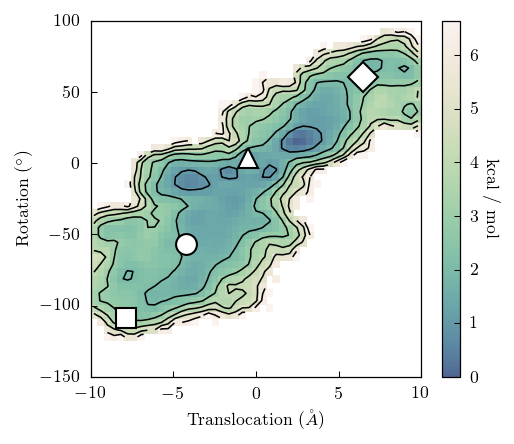

In [14]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff * 0.593, levels=clines, colors="black")
plotting.format_cvs(ax, centroids=True)
f.tight_layout()

In [15]:
sb_ids = [42, 48, 47, 53]

In [16]:
# PMFs in sb space
pmfs_sb = []
sb1_lim = []
sb2_lim = []
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs[:237]]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs[:237]]
    xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 100)
    ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 100)
    sb1_lim.append(xlim)
    sb2_lim.append(ylim)
    pmfs_sb.append(extq.projection.density2d(sb1_trajs, sb2_trajs, weights, xlim, ylim))

/tmp/jobs/16820110/ipykernel_291882/2522672989.py:11: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(p.T) - min_energy


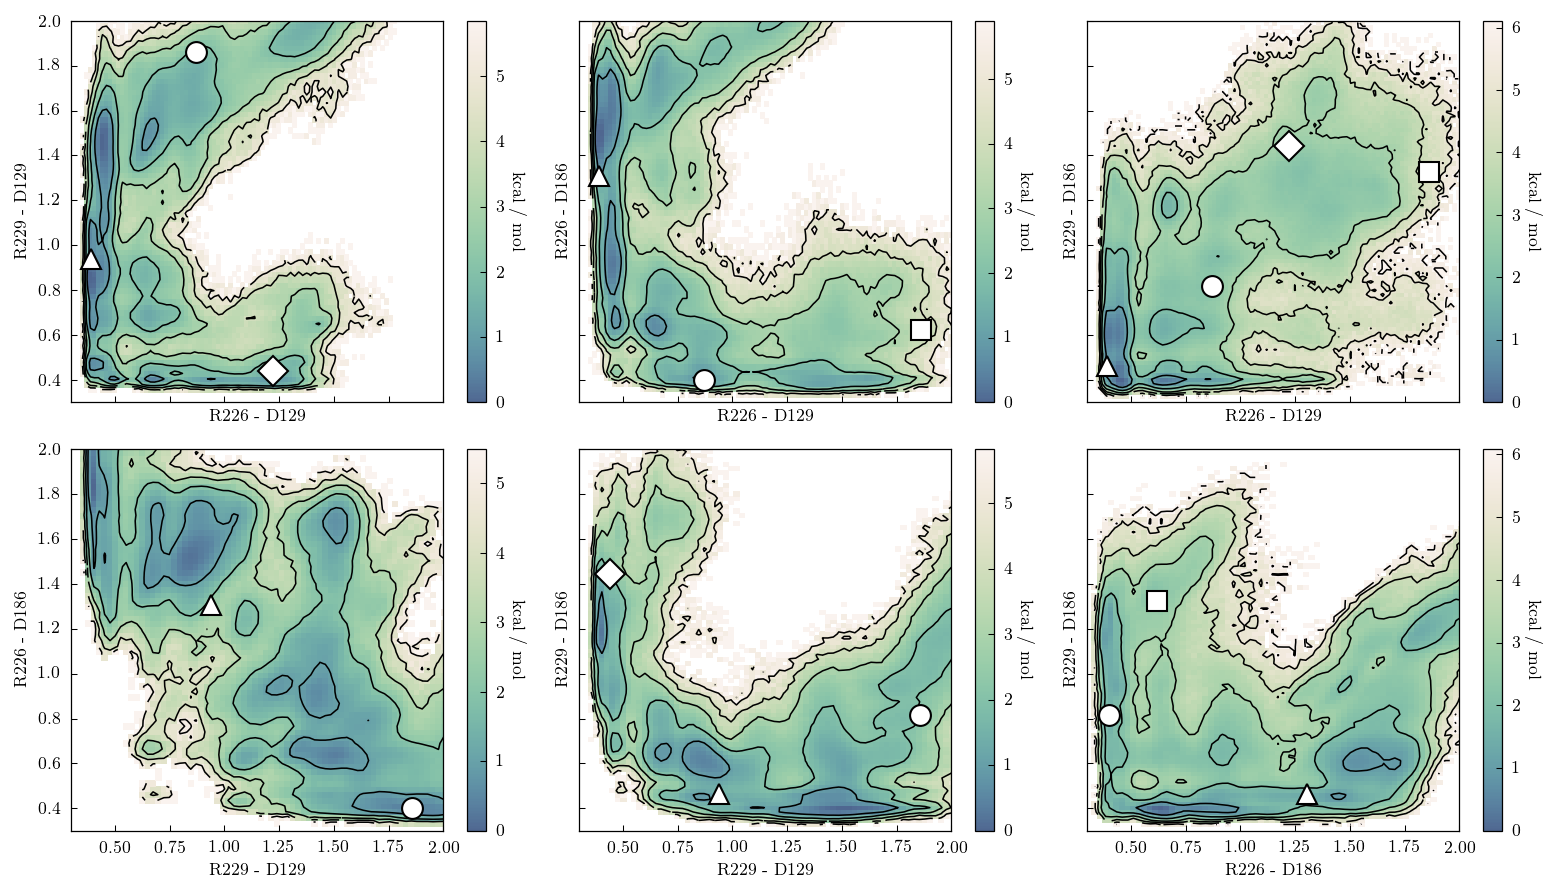

In [17]:
clines = np.linspace(0, 6, 7)
f, axes = plt.subplots(2, 3, figsize=(10.5, 6), sharex=True, sharey=True)

for ((sb1, sb2), ax, p, xlim, ylim) in zip(
    combinations(sb_ids, 2), axes.flat, pmfs_sb, sb1_lim, sb2_lim
):
    # compute grid
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    # calculate energy difference against minimum
    min_energy = np.min(-np.log(p[np.nonzero(p)]))
    diff = -np.log(p.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
    ax.contour(
        centerx,
        centery,
        diff * 0.593,
        levels=clines,
        colors="black",
        linestyles="solid",
    )
    cb = plt.colorbar(h, ax=ax)
    cb.set_label("kcal / mol", rotation=-90, labelpad=10)
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")
    ax.set_xlim([0.3, 2.0])
    ax.set_ylim([0.3, 2.0])

plotting.plot_sb_models(axes.flat, centroids=True)
f.tight_layout()

# Seeds for SMD for Anton simulations

In [18]:
smd_seeds = []
sb_suppl_arr = sb_arr[3_000_000:]

In [19]:
# R226-D129 and R229-D129
for i in util.find_closest_points((0.6, 0.8), sb_suppl_arr[:, [42, 48]]):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    smd_seeds.append((i // 3000, i % 3000))
for i in util.find_closest_points((0.55, 1.1), sb_suppl_arr[:, [42, 48]]):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    smd_seeds.append((i // 3000, i % 3000))

# R226-D129 and R226-D186
for i in util.find_closest_points((0.5, 0.5), sb_suppl_arr[:, [42, 47]]):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    smd_seeds.append((i // 3000, i % 3000))
for i in util.find_closest_points((0.8, 1.0), sb_suppl_arr[:, [42, 47]]):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    smd_seeds.append((i // 3000, i % 3000))

# R229-D129 and R229-D186
for i in util.find_closest_points((1.25, 0.6), sb_suppl_arr[:, [48, 53]]):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    smd_seeds.append((i // 3000, i % 3000))

# R226-D186 and R229-D186
for i in util.find_closest_points((0.6, 0.5), sb_suppl_arr[:, [47, 53]]):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    smd_seeds.append((i // 3000, i % 3000))

../../unbiased/085/civsd-4.nc 27
../../unbiased/091/civsd-2.nc 2429
../../unbiased/293/civsd-2.nc 1084
../../unbiased/115/civsd.nc 1103
../../unbiased/102/civsd-2.nc 52
../../unbiased/284/civsd.nc 2907


In [20]:
start_folder = 28
for n, (i, j) in enumerate(smd_seeds):
    frame = md.load_netcdf(
        traj_files[i], top="../../unbiased/000/civsd.prmtop", frame=j
    )
    new_folder = f"../../biased/smd-prep/run{start_folder + n}"
    if not os.path.exists(new_folder):
        os.mkdir(new_folder)
    pdb_file = f"{new_folder}/civsd.pdb"
    #     frame.atom_slice(frame.topology.select('protein')).save_pdb(pdb_file)
    frame.save_pdb(pdb_file)

In [21]:
# removed waters and set weights
for i in range(28, 34):
    file = f"../../biased/smd-prep/run{i}/civsd.pdb"
    util.zero_h_occupancy(
        file, new_file_name=f"../../biased/smd-prep/run{i}/civsd-nowat.pdb", savelines=3
    )

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:421: PDBConstructionWarning: PDBConstructionException: Atom H defined twice in residue <Residue GLN het=  resseq=133 icode= > at line 2193.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  PDBConstructionWarning,
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 0, ' ') redefined at line 54588.
  PDBConstructionWarning,
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:421: PDBConstructionWarning: PDBConstructionException: Blank altlocs in duplicate residue HOH (' ', 0, ' ') at line 54588.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  PDBConstructionWarning,
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residu

In [74]:
util.zero_h_occupancy("../../biased/smd-prep/run22/start.pdb", savelines=1)

# Check seeds

In [17]:
feat = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
pair_indices = np.loadtxt("../../data/feat3_atom_indices.txt", dtype=int)
feat.add_distances(pair_indices)
print(feat.describe())

['DIST: ARG 217 CA 1768 - ASP 129 CA 406', 'DIST: ARG 217 CA 1768 - ASP 136 CA 530', 'DIST: ARG 217 CA 1768 - ASP 151 CA 751', 'DIST: ARG 217 CA 1768 - ASP 164 CA 944', 'DIST: ARG 217 CA 1768 - GLU 183 CA 1258', 'DIST: ARG 217 CA 1768 - ASP 186 CA 1299', 'DIST: ARG 223 CA 1872 - ASP 129 CA 406', 'DIST: ARG 223 CA 1872 - ASP 136 CA 530', 'DIST: ARG 223 CA 1872 - ASP 151 CA 751', 'DIST: ARG 223 CA 1872 - ASP 164 CA 944', 'DIST: ARG 223 CA 1872 - GLU 183 CA 1258', 'DIST: ARG 223 CA 1872 - ASP 186 CA 1299', 'DIST: ARG 226 CA 1934 - ASP 129 CA 406', 'DIST: ARG 226 CA 1934 - ASP 136 CA 530', 'DIST: ARG 226 CA 1934 - ASP 151 CA 751', 'DIST: ARG 226 CA 1934 - ASP 164 CA 944', 'DIST: ARG 226 CA 1934 - GLU 183 CA 1258', 'DIST: ARG 226 CA 1934 - ASP 186 CA 1299', 'DIST: ARG 229 CA 1990 - ASP 129 CA 406', 'DIST: ARG 229 CA 1990 - ASP 136 CA 530', 'DIST: ARG 229 CA 1990 - ASP 151 CA 751', 'DIST: ARG 229 CA 1990 - ASP 164 CA 944', 'DIST: ARG 229 CA 1990 - GLU 183 CA 1258', 'DIST: ARG 229 CA 1990 - A

In [21]:
traj_files = []
for i in range(28, 34):
    if i == 28:
        infile = f"../../biased/smd-prep/run{i}/run0.nc"
    else:
        infile = f"../../biased/smd-prep/run{i}/run1.nc"
    outfile = f"../../biased/smd-prep/run{i}/run0_prot.xtc"
    traj_files.append(outfile)

    # strip waters and lipids
    trj = md.load_netcdf(infile, top="../../biased/smd-prep/civsd.prmtop")
    trj.atom_slice(trj.topology.select("protein")).save_xtc(
        outfile, force_overwrite=True
    )

In [22]:
sb_smd = pyemma.coordinates.load(traj_files, features=feat, chunksize=32)

In [23]:
sb_smd[0].shape

(1000, 60)

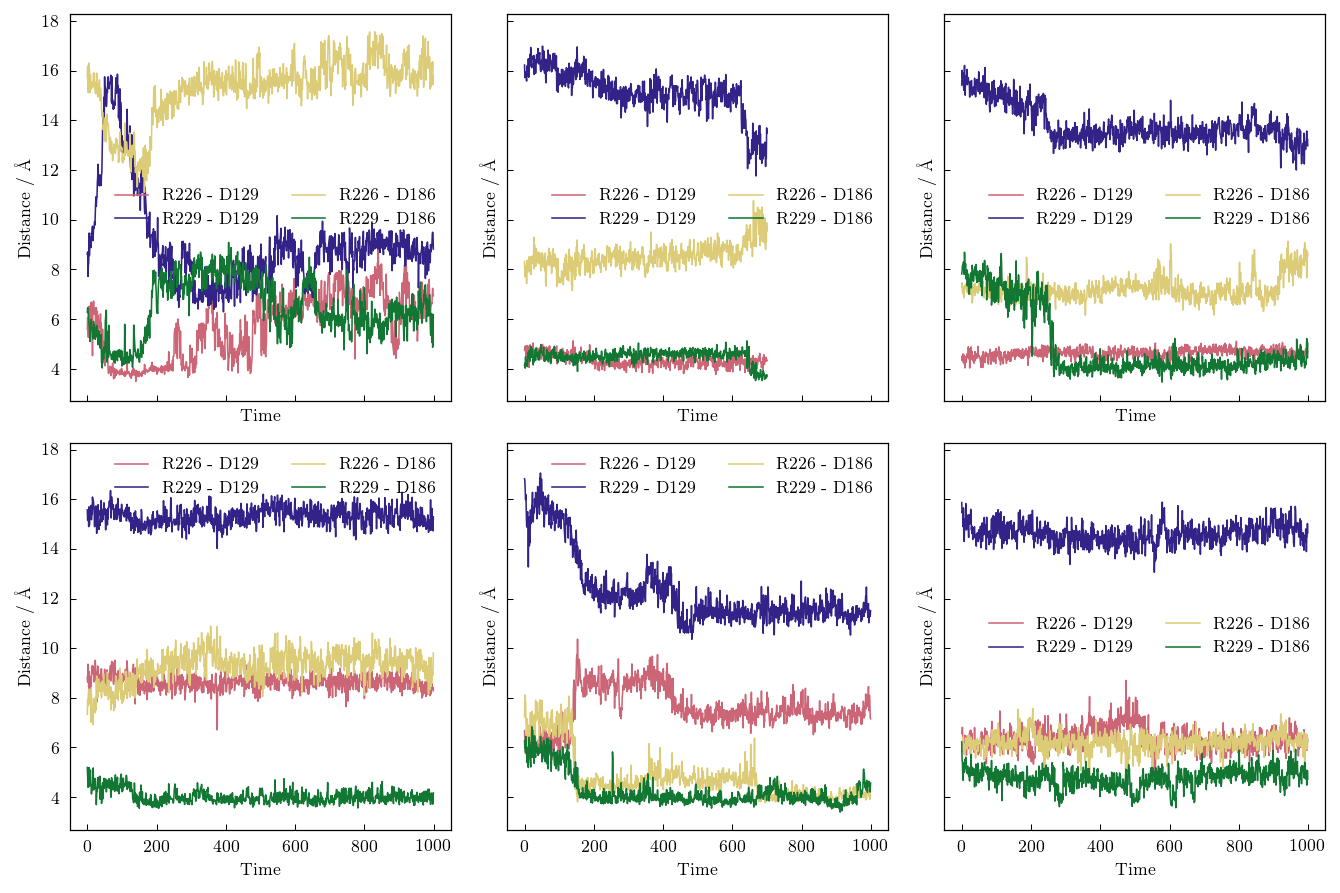

In [26]:
f, axs = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
for ax, traj in zip(axs.flat, sb_smd):
    for i in sb_ids:
        ax.plot(traj[..., i] * 10)
    ax.legend(["R226 - D129", "R229 - D129", "R226 - D186", "R229 - D186"], ncol=2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Distance / Å")
f.tight_layout()

In [25]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

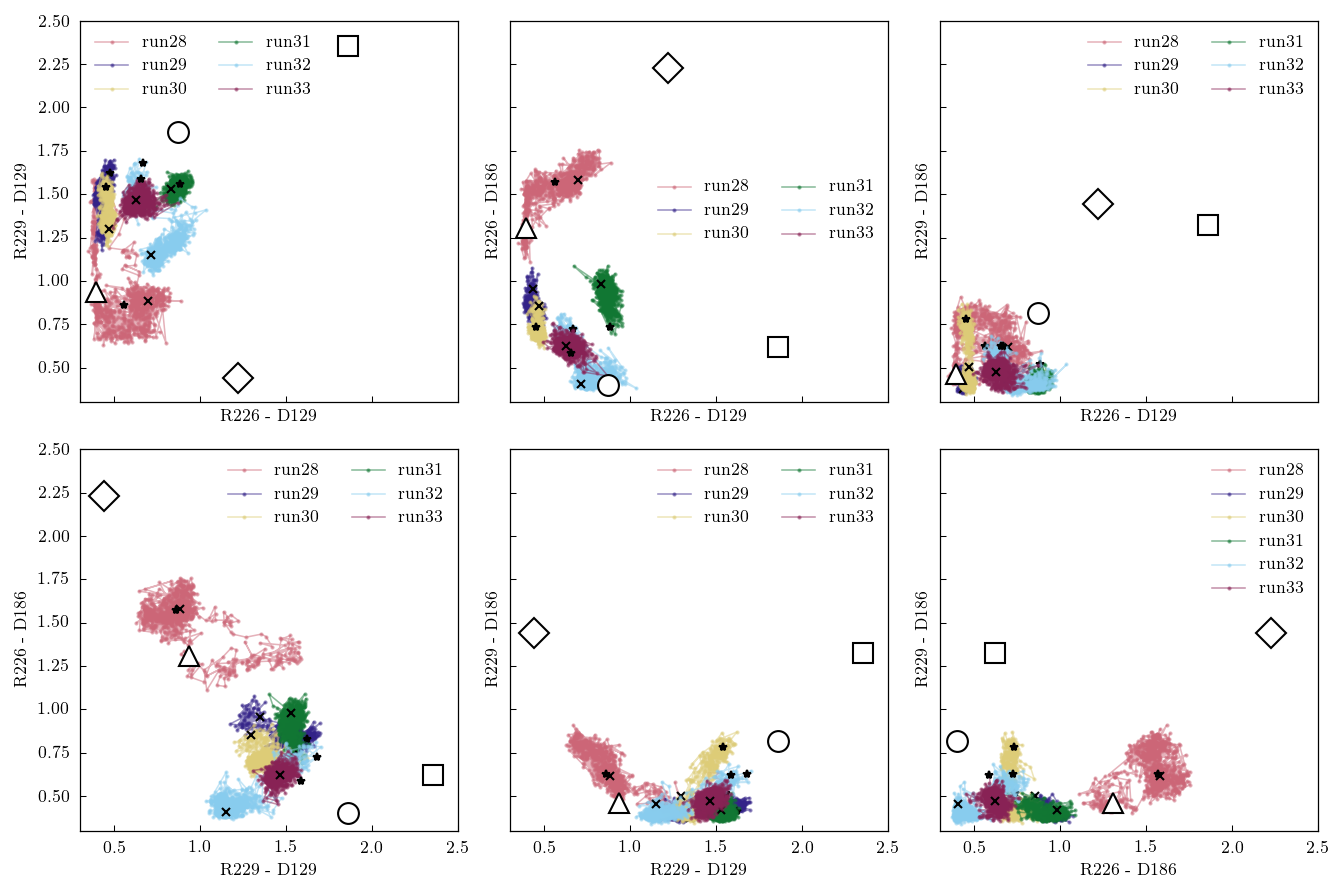

In [28]:
f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    for i, traj in enumerate(sb_smd):
        ax.plot(traj[..., sb1], traj[..., sb2], ".-", alpha=0.5, label=f"run{i + 28}")
        ax.plot(traj[0, sb1], traj[0, sb2], "k*", ms=4)
        ax.plot(traj[-1, sb1], traj[-1, sb2], "kx", ms=4)
    ax.set(xlabel=f"{sb_labels[sb1 - 30]}", ylabel=f"{sb_labels[sb2 - 30]}")
    ax.legend(ncol=2)

axes[0][0].set(xlim=[0.3, 2.5], ylim=[0.3, 2.5])
plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
f.tight_layout()
plt.legend()

# New seeds for S4 helix positioning

1.3.22

In [20]:
q = np.load("../../data/feat2_dist_du_suppl_2/q_downup.npy", allow_pickle=True)[5]

In [21]:
len(q), q[0].shape

(480, (10000,))

In [27]:
q_suppl_arr = np.concatenate(q)[3_000_000:, None]
cv_suppl_arr = cv_arr[3_000_000:]

In [38]:
smd_seeds, seed_ids = [], []
for i in util.find_closest_points([0.5], q_suppl_arr, n=20):
    traj = i // 3000
    print(f"{traj_files[i // 3000]} {i % 3000}")
    # smd_seeds.append((i // 3000, i % 3000))
    seed_ids.append(i)

../../unbiased/281/civsd-3.nc 1545
../../unbiased/266/civsd-2.nc 247
../../unbiased/088/civsd-2.nc 2353
../../unbiased/101/civsd-4.nc 261
../../unbiased/267/civsd-3.nc 1617
../../unbiased/142/civsd.nc 2043
../../unbiased/098/civsd-3.nc 742
../../unbiased/288/civsd-1.nc 483
../../unbiased/101/civsd.nc 2345
../../unbiased/116/civsd.nc 386
../../unbiased/289/civsd-1.nc 813
../../unbiased/101/civsd.nc 748
../../unbiased/122/civsd.nc 100
../../unbiased/095/civsd-3.nc 1116
../../unbiased/101/civsd-3.nc 295
../../unbiased/148/civsd.nc 177
../../unbiased/142/civsd.nc 903
../../unbiased/101/civsd.nc 2
../../unbiased/283/civsd.nc 643
../../unbiased/289/civsd-1.nc 632


/tmp/jobs/16820110/ipykernel_291882/4199266867.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


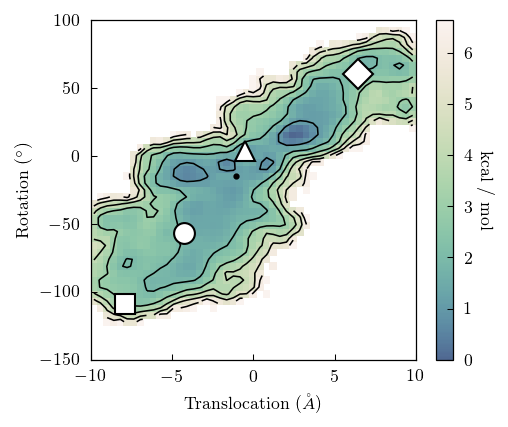

In [47]:
f, ax = plt.subplots(figsize=(3.5, 3))

xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff * 0.593, levels=clines, colors="black")
plotting.format_cvs(ax, centroids=True)
ax.plot(cv_suppl_arr[seed_ids[3], 0], cv_suppl_arr[seed_ids[3], 1], ".k", ms=4)

/tmp/jobs/16820110/ipykernel_291882/501835687.py:11: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(p.T) - min_energy


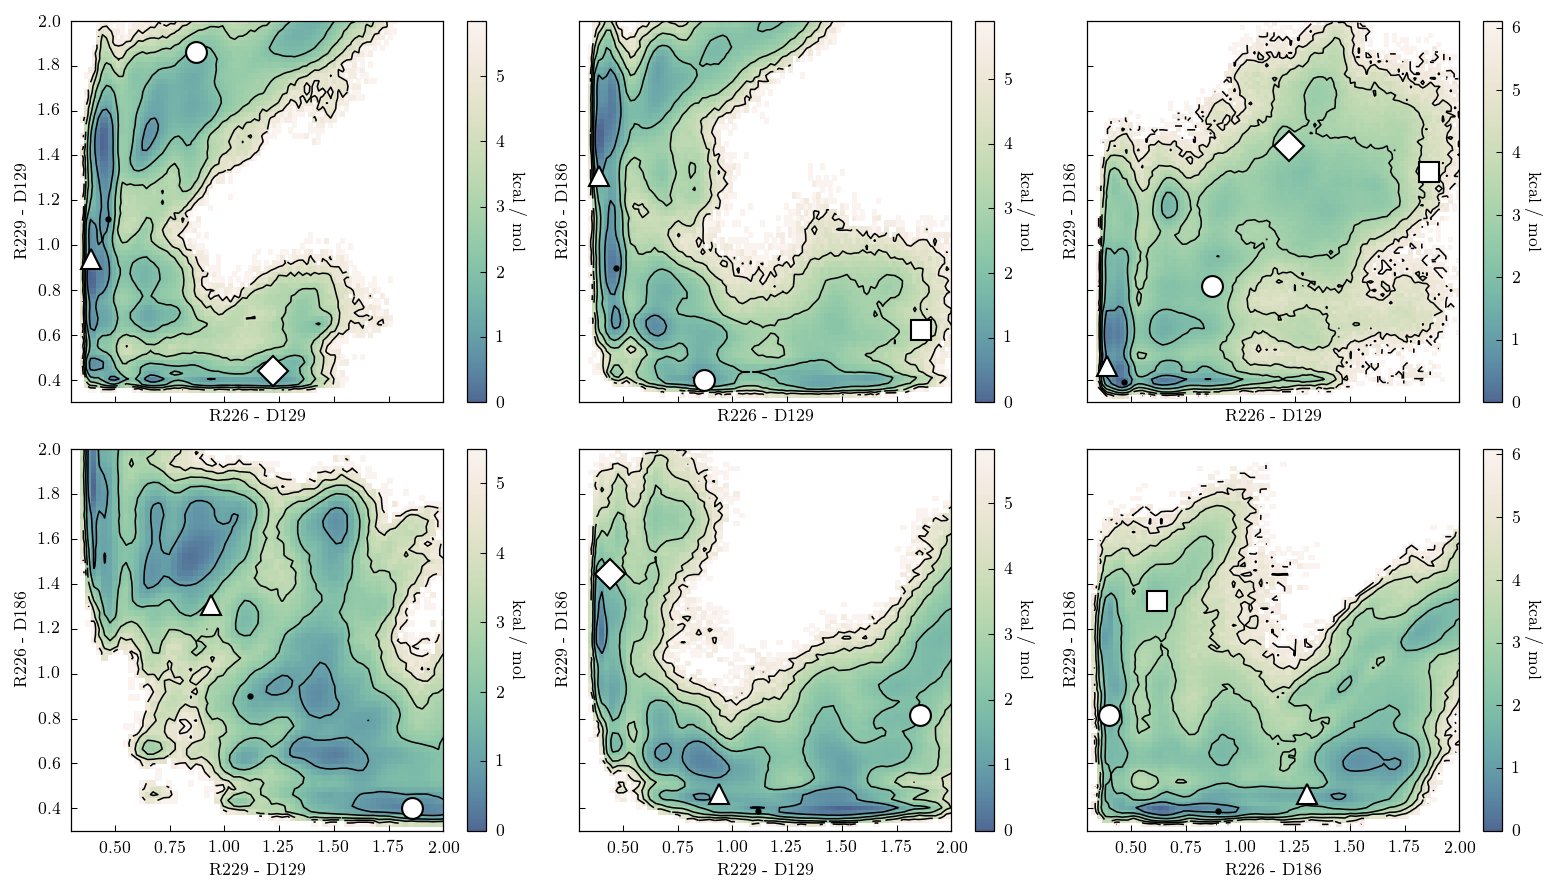

In [43]:
clines = np.linspace(0, 6, 7)
f, axes = plt.subplots(2, 3, figsize=(10.5, 6), sharex=True, sharey=True)

for ((sb1, sb2), ax, p, xl, yl) in zip(
    combinations(sb_ids, 2), axes.flat, pmfs_sb, sb1_lim, sb2_lim
):
    # compute grid
    centerx = (xl[1:] + xl[:-1]) / 2
    centery = (yl[1:] + yl[:-1]) / 2

    # calculate energy difference against minimum
    min_energy = np.min(-np.log(p[np.nonzero(p)]))
    diff = -np.log(p.T) - min_energy
    h = ax.pcolor(xl, yl, diff * 0.593, cmap=cm_seq)
    ax.contour(
        centerx,
        centery,
        diff * 0.593,
        levels=clines,
        colors="black",
        linestyles="solid",
    )
    cb = plt.colorbar(h, ax=ax)
    cb.set_label("kcal / mol", rotation=-90, labelpad=10)
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")
    ax.set_xlim([0.3, 2.0])
    ax.set_ylim([0.3, 2.0])

    ax.plot(sb_suppl_arr[seed_ids[2], sb1], sb_suppl_arr[seed_ids[2], sb2], ".k", ms=4)

plotting.plot_sb_models(axes.flat, centroids=True)
f.tight_layout()

# Adaptive sampling

In [18]:
# def Sensitivity_General(basis, guess, d_binned, weights):
#     """Computes the optimal sampling distribution for
#     a (set of) collective variable(s).

#     Parameters
#     ----------
#     basis : list of (2, nbasis) ndarray of float
#         Basis set evaluated at start and end of trajectories.
#     guess : list of (2,) ndarray of float
#         DGA guess function evaluated at start and end of trajectories.
#     d_binned : list of (2, nbins) ndarray of float
#         Indicator function for start and end of trajectories in each CV bin.
#     weights : (nbins,) ndarray of float
#         Weights for start/end of trajectory for binned into CVs.

#     Returns
#     -------
#     ans : (nbins,) ndarray of float
#         Optimal sampling distribution weights for CV bins.
#     """
#     ntraj = len(basis)
#     nbasis = basis[0].shape[-1]
#     nbins = d_binned[0].shape[-1]
#     L_samp = [(b[1] - b[0]) for b in basis]
#     LR_samp = [(g[0] - g[1]) for g in guess]

#     # a_samp/c_samp are list of matrices with shape (nbasis, nbasis)
#     # r_samp is list of vectors with shape (nbasis,)
#     a_samp, c_samp, r_samp = [], [], []
#     for (b, L, LR) in zip(basis, L_samp, LR_samp):
#         a_samp.append(np.einsum('i,j->ij', b[0], L))
#         c_samp.append(np.einsum('i,j->ij', b[0], b[0]))
#         r_samp.append(b[0] * LR)


#     Ahat = np.zeros_like(a_samp[0])
#     Chat = np.zeros_like(a_samp[0])
#     bhat = np.zeros_like(r_samp[0])
#     for (a, c, r, db) in zip(a_samp, c_samp, r_samp, d_binned):
#         for i in range(nbins):
#             if np.sum(db[0, i]) > 0:
#                 inds = np.where(db[0, i] == 1)[0] # occupied bins
#                 Ahat += np.sum(weights[i]*a[inds], axis=0) / len(inds)
#                 Chat += np.sum(weights[i]*c[inds], axis=0) / len(inds)
#                 bhat += np.sum(weights[i]*r[inds]) / len(inds)
#                 # print(i)

#     vdga = np.linalg.solve(Ahat, bhat) # DGA estimate for coefficients (x)
#     RMAV = [r - np.einsum('ij,j->i', a, vdga) for (r, a) in zip(r_samp, a_samp)]
#     Linv = np.linalg.inv(M)
#     Mat = Linv @ Chat @ Linv

#     ans = np.zeros(nbins)
#     for db, rm in zip(d_binned, RMAV):
#         for i in range(nbins):
#             if np.sum(db[0, i]) > 0:
#                 inds = np.where(db[0, i] == 1)[0]
#                 R = np.sum(rm[inds]) / len(inds)
#                 Vi_num = np.sum(db[0, i][:,None] * ((rm-R) @ Mat) * (rm-R))
#                 Vi_denom = np.sum(db[0, i])
#                 ans[i] = weights[i] * np.sqrt(Vi_num / Vi_denom)
#             # print(i)
#     return ans

## states

In [49]:
basis = np.load(
    "../../data/raw_feat/feat2_ivac_ind1000_suppl_02_merged.npy", allow_pickle=True
)
print(len(basis), basis[0].shape)

480 (10000,)


In [50]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
in_A = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
in_B = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [51]:
d = ~(in_A | in_B)

In [52]:
assert (np.count_nonzero(in_A) + np.count_nonzero(in_B) + np.count_nonzero(d)) == len(
    cv_arr
)
print(f"Number of down structures:  {np.count_nonzero(in_A)}")
print(f"Number of up structures:   {np.count_nonzero(in_B)}")
print(f"Number of other structures: {np.count_nonzero(d)}")

Number of down structures:  40649
Number of up structures:   6649
Number of other structures: 3681702


In [53]:
traj_inds = util.split_indices(cv_trajs)

In [54]:
nbasis = 1000
b = np.zeros((len(basis), 2, nbasis))
for i, bas in enumerate(basis):
    init, fin = bas[0], bas[-1]
    b[i, 0, init] = 1
    b[i, -1, fin] = 1
g = np.split(in_B, traj_inds)
g = np.asarray([guess[[0, -1]] for guess in g], dtype=float)

In [55]:
b.shape, g.shape

((480, 2, 1000), (480, 2))

## Salt bridges 0 and 1

In [56]:
from scipy.stats import binned_statistic_2d

In [65]:
sb0_start = np.array([traj[0, sb_ids[0]] for traj in sb_trajs])
sb1_start = np.array([traj[0, sb_ids[1]] for traj in sb_trajs])

In [67]:
sb0_start.shape, sb1_start.shape

((480,), (480,))

In [187]:
ret = binned_statistic_2d(
    sb0_start,
    sb1_start,
    None,
    "count",
    bins=[8, 18],
    range=[[0.4, 0.8], [0.9, 1.8]],
    expand_binnumbers=True,
)
indices, xe, ye = ret.binnumber, ret.x_edge, ret.y_edge
indices_long = np.ravel_multi_index(indices, (10, 20))

In [188]:
xe, ye

(array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ],
       dtype=float32),
 array([0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 ,
        1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 ], dtype=float32))

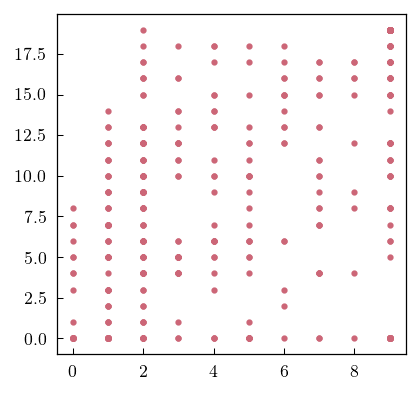

In [189]:
plt.scatter(*indices)

In [190]:
unique, indices_renumber = np.unique(indices_long, return_inverse=True)

In [191]:
n_unique = len(unique)
total = len(sb0_start)
d_binned = np.zeros((total, n_unique))
d_binned[np.arange(total), indices_renumber] += 1
d_binned = d_binned.reshape(480, -1, order="F")

In [192]:
d_binned.shape

(480, 127)

In [75]:
weights = np.load("../../data/feat2_dist_du_suppl_2/weights.npy", allow_pickle=True)[0]

In [78]:
w_start = np.array([weight[0] for weight in weights])

In [79]:
w_start.shape

(480,)

In [193]:
weights_binned, xeh, yeh = np.histogram2d(
    sb0_start,
    sb1_start,
    bins=[10, 20],
    range=[[0.35, 0.85], [0.85, 1.85]],
    weights=w_start,
    density=True,
)

In [194]:
weights_unique = np.ravel(weights_binned)[unique]

In [195]:
assert np.all(unique[indices_renumber] == indices_long)

In [136]:
def Sensitivity_General(Basis, Guess, DTheta, W):
    ntraj = len(Basis)
    nbasis = len(Basis[0, 0, :])
    L_samp = Basis[:, 1] - Basis[:, 0]
    LR_samp = Guess[:, 0] - Guess[:, 1]
    print(LR_samp.shape)
    print(L_samp.shape)
    ans = np.zeros(len(DTheta[0]))
    A_Samp = np.einsum("ij,ik->ijk", Basis[:, 0], L_samp)
    C_Samp = np.einsum("ij,ik->ijk", Basis[:, 0], Basis[:, 0])
    R_Samp = np.einsum("ij,i->ij", Basis[:, 0], LR_samp)
    M = np.zeros_like(A_Samp[0])
    C = np.zeros_like(A_Samp[0])
    r = np.zeros_like(R_Samp[0])
    for i in range(len(ans)):
        if np.sum(DTheta[:, i]) > 0:
            inds = np.where(DTheta[:, i] == 1)[0]
            C += np.sum(W[i] * C_Samp[inds], axis=0) / len(inds)
            M += np.sum(W[i] * A_Samp[inds], axis=0) / len(inds)
            r += np.sum(W[i] * R_Samp[inds], axis=0) / len(inds)
            # print(f"{i}: {inds}")
    vdga = np.linalg.solve(M, r)
    RMAV = R_Samp - np.einsum("ijk,k->ij", A_Samp, vdga)
    LInv = np.linalg.inv(M)
    Mat = LInv.T @ C @ LInv
    print(RMAV)
    print(Mat)
    for i in range(len(ans)):
        if np.sum(DTheta[:, i]) > 0:
            inds = np.where(DTheta[:, i] == 1)[0]
            R = np.sum(RMAV[inds]) / len(inds)
            ans[i] = (W[i]) * (
                np.sum(DTheta[:, i][:, None] * ((RMAV - R) @ Mat) * (RMAV - R))
                / np.sum(DTheta[:, i])
            ) ** 0.5
    return ans

In [106]:
d_down_arr = np.load("../../data/feat2_dist_du_suppl_2/dist_down.npy")
d_up_arr = np.load("../../data/feat2_dist_du_suppl_2/dist_up.npy")
print(d_down_arr.shape)

(3729000, 1)


In [108]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)
# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
# boundary conditions
smooth[~d] = 0
guess_up[in_B] = 1
guess_up[in_A] = 0
guess_down[in_A] = 1
guess_down[in_B] = 0

In [112]:
def orthogonalize(basis, pi):
    numer, denom = 0, 0
    for b, p in zip(basis, pi):
        numer += np.einsum("m,mi,mj->ij", p, b, b)
        denom += np.sum(p)
    evals, evecs = scipy.linalg.eigh(numer / denom)
    coeffs = evecs / np.sqrt(evals)[None, :]
    return [b @ coeffs for b in basis]

In [113]:
basis_d = np.split(smooth * sb_arr, traj_inds)
basis_d = orthogonalize(basis_d, weights)

In [117]:
basis_d = np.concatenate(basis_d)
basis_d[~d] = 0
basis_d = np.split(basis_d, traj_inds)

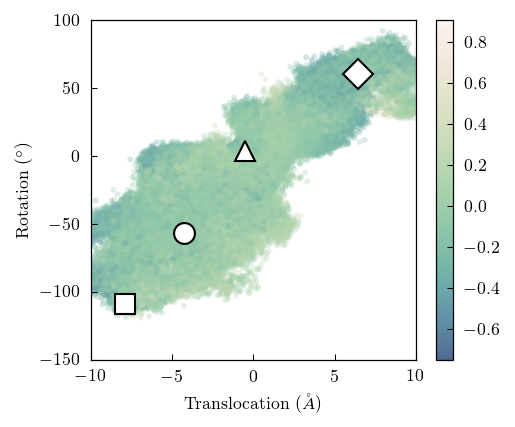

In [118]:
# Plot smoothing function
random.seed(123)
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)
fig, ax = plt.subplots(figsize=(3.5, 3))
h = ax.scatter(
    cv_arr[inds, 0],
    cv_arr[inds, 1],
    c=np.mean(np.concatenate(basis_d), axis=-1)[inds],
    alpha=0.2,
    cmap=cm_seq,
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax)

In [121]:
b_dist = np.array([basis[[0, -1], :] for basis in basis_d])
guess_up = np.split(guess_up, traj_inds)
g_dist = np.array([guess[[0, -1]] for guess in guess_up])

In [122]:
b_dist.shape, g_dist.shape

((480, 2, 60), (480, 2, 1))

In [196]:
# perform sensitivity compuation
ans = Sensitivity_General(b_dist, np.squeeze(g_dist), d_binned, weights_unique)

(480,)
(480, 60)
[[-0.2511741   0.11179467 -0.35740385 ... -0.30319577  0.26530004
  -0.1714171 ]
 [-0.01121428 -0.03960805 -0.1378144  ... -0.13394304  0.19137736
  -0.11001958]
 [-0.54178718  0.21548083 -0.04718497 ... -0.17948568  0.378332
  -0.21677829]
 ...
 [-0.09185592 -0.05830502  0.09027201 ...  0.00966615 -0.09366973
   0.05962901]
 [-0.02329746 -0.0548635   0.00841685 ...  0.00159348  0.06268917
  -0.09298578]
 [-0.06378977  0.24545902  0.21715971 ... -0.10572875  0.14934827
  -0.24764366]]
[[ 4.06249342e-01 -1.83806291e-01  4.27013934e+00 ...  4.04841552e+00
   2.49531606e+00  1.00714756e+01]
 [-1.83806291e-01  1.92827599e-01 -2.36336723e+00 ... -1.78611749e+00
  -5.84412571e-01 -4.89882458e+00]
 [ 4.27013934e+00 -2.36336723e+00  4.89453245e+01 ...  4.44937071e+01
   2.56865749e+01  1.12923641e+02]
 ...
 [ 4.04841552e+00 -1.78611749e+00  4.44937071e+01 ...  4.33806472e+01
   2.73341740e+01  1.06076400e+02]
 [ 2.49531606e+00 -5.84412571e-01  2.56865749e+01 ...  2.73341740e+0

In [197]:
ans_bin = np.zeros(200)
ans_bin[unique] = ans

Text(0, 0.5, 'R229 - D129')

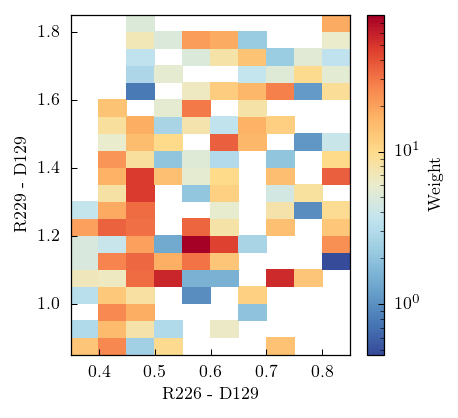

In [198]:
f = plt.figure()
plt.pcolor(
    xeh, yeh, np.reshape(ans_bin.T, (10, 20)).T, cmap=cm_div, norm=mpl.colors.LogNorm()
)
cb = plt.colorbar(label="Weight")
plt.xlabel(sb_labels[sb_ids[0] - 30])
plt.ylabel(sb_labels[sb_ids[1] - 30])

## Repeat with salt bridges 0 and 2 (R226)

In [162]:
sb2_start = np.array([traj[0, sb_ids[2]] for traj in sb_trajs])

In [169]:
ret = binned_statistic_2d(
    sb0_start,
    sb2_start,
    None,
    "count",
    bins=[8, 18],
    range=[[0.4, 0.8], [0.4, 1.3]],
    expand_binnumbers=True,
)
indices, xe, ye = ret.binnumber, ret.x_edge, ret.y_edge
indices_long = np.ravel_multi_index(indices, (10, 20))

In [170]:
xe, ye

(array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ],
       dtype=float32),
 array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
        0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 ], dtype=float32))

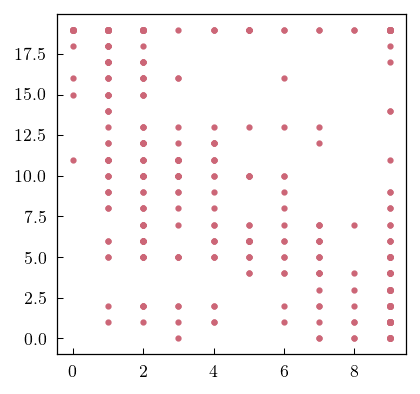

In [171]:
plt.scatter(*indices)

In [172]:
unique, indices_renumber = np.unique(indices_long, return_inverse=True)

In [173]:
n_unique = len(unique)
total = len(sb0_start)
d_binned = np.zeros((total, n_unique))
d_binned[np.arange(total), indices_renumber] += 1
d_binned = d_binned.reshape(480, -1, order="F")

In [174]:
d_binned.shape

(480, 114)

In [175]:
weights_binned, xeh, yeh = np.histogram2d(
    sb0_start,
    sb2_start,
    bins=[10, 20],
    range=[[0.35, 0.85], [0.35, 1.35]],
    weights=w_start,
    density=True,
)

In [176]:
weights_unique = np.ravel(weights_binned)[unique]

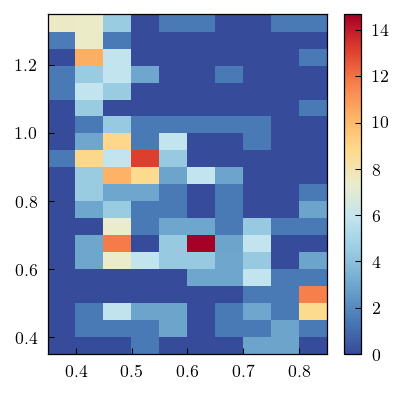

In [178]:
plt.pcolor(xeh, yeh, weights_binned.T, cmap=cm_div)
plt.colorbar()

In [179]:
ans2 = Sensitivity_General(b_dist, np.squeeze(g_dist), d_binned, weights_unique)

(480,)
(480, 60)
[[-1.88770067e-01  8.40193622e-02 -2.68607112e-01 ... -2.27866988e-01
   1.99386432e-01 -1.28828638e-01]
 [-1.70848563e-03 -6.03425129e-03 -2.09959023e-02 ... -2.04061034e-02
   2.91561719e-02 -1.67613857e-02]
 [ 2.80367709e+00 -1.11508485e+00  2.44175996e-01 ...  9.28814712e-01
  -1.95781815e+00  1.12179903e+00]
 ...
 [ 4.97207289e-01  3.15599472e-01 -4.88633720e-01 ... -5.23219278e-02
   5.07025249e-01 -3.22766120e-01]
 [ 1.50626978e-01  3.54713452e-01 -5.44181207e-02 ... -1.03024290e-02
  -4.05309438e-01  6.01188576e-01]
 [ 3.60784384e-01 -1.38827558e+00 -1.22821933e+00 ...  5.97984285e-01
  -8.44689059e-01  1.40063154e+00]]
[[ 1.34384204e+00 -3.25673098e+00  3.22926870e+00 ... -1.05264190e+01
   3.95259193e-01 -1.43843118e+01]
 [-3.25673098e+00  8.05793527e+00 -7.98845685e+00 ...  2.60648911e+01
  -6.05931030e-01  3.57685322e+01]
 [ 3.22926870e+00 -7.98845685e+00  7.97559736e+00 ... -2.59008039e+01
   9.89008063e-01 -3.50857524e+01]
 ...
 [-1.05264190e+01  2.606489

In [180]:
ans2_bin = np.zeros(200)
ans2_bin[unique] = ans2

Text(0, 0.5, 'R226 - D186')

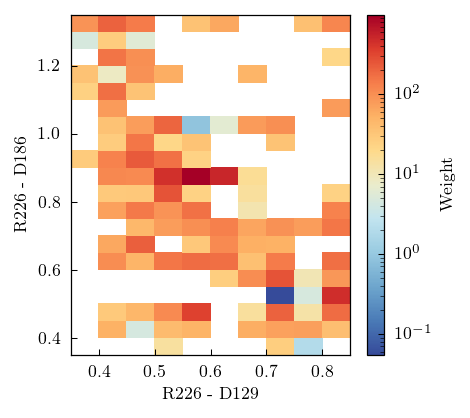

In [185]:
f = plt.figure()
plt.pcolor(
    xeh, yeh, np.reshape(ans2_bin.T, (10, 20)).T, cmap=cm_div, norm=mpl.colors.LogNorm()
)
cb = plt.colorbar(label="Weight")
plt.xlabel(sb_labels[sb_ids[0] - 30])
plt.ylabel(sb_labels[sb_ids[2] - 30])

## Repeat for translocation/rotation

In [199]:
dist_start = np.array([traj[0, 0] for traj in cv_trajs])
rot_start = np.array([traj[0, 1] for traj in cv_trajs])

In [200]:
ret = binned_statistic_2d(
    dist_start,
    rot_start,
    None,
    "count",
    bins=[10, 13],
    range=[[-5, 0], [-55, 10]],
    expand_binnumbers=True,
)
indices, xe, ye = ret.binnumber, ret.x_edge, ret.y_edge
indices_long = np.ravel_multi_index(indices, (12, 15))

In [201]:
xe, ye

(array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ]),
 array([-55., -50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,
          0.,   5.,  10.]))

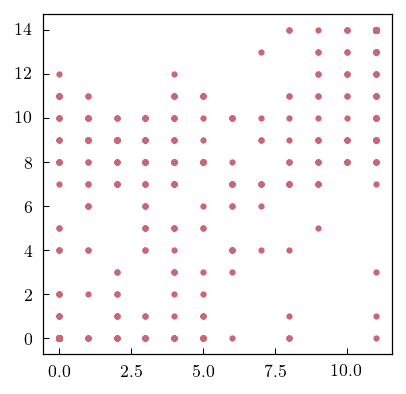

In [202]:
plt.scatter(*indices)

In [203]:
unique, indices_renumber = np.unique(indices_long, return_inverse=True)

In [204]:
n_unique = len(unique)
total = len(sb0_start)
d_binned = np.zeros((total, n_unique))
d_binned[np.arange(total), indices_renumber] += 1
d_binned = d_binned.reshape(480, -1, order="F")

In [205]:
d_binned.shape

(480, 108)

In [209]:
weights_binned, xeh, yeh = np.histogram2d(
    dist_start,
    rot_start,
    bins=[12, 15],
    range=[[-5.5, 0.5], [-60, 15]],
    weights=w_start,
    density=True,
)

In [210]:
weights_unique = np.ravel(weights_binned)[unique]

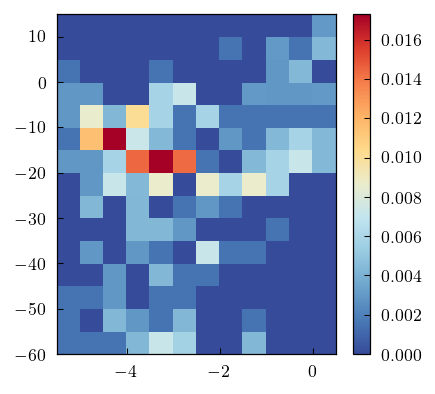

In [211]:
plt.pcolor(xeh, yeh, weights_binned.T, cmap=cm_div)
plt.colorbar()

In [214]:
ans3 = Sensitivity_General(b_dist, np.squeeze(g_dist), d_binned, weights_unique)

(480,)
(480, 60)
[[-0.40936527  0.18220372 -0.58249925 ... -0.49415054  0.43238784
  -0.27937676]
 [-0.02365117 -0.08353428 -0.29065372 ... -0.28248892  0.40361922
  -0.2320338 ]
 [ 0.07405339 -0.02945269  0.00644941 ...  0.02453274 -0.05171176
   0.02963003]
 ...
 [ 0.06523993  0.04141067 -0.06411497 ... -0.0068653   0.06652817
  -0.04235103]
 [ 0.01467762  0.03456452 -0.00530269 ... -0.0010039  -0.03949476
   0.05858191]
 [-0.01661304  0.06392594  0.05655583 ... -0.02753539  0.03889541
  -0.0644949 ]]
[[  2568.5310149   -3939.75451146   3671.05931653 ...   -353.56373155
   -8669.10980288   -961.09748586]
 [ -3939.75451146   6140.12080772  -5805.95221143 ...    521.49754016
   13291.02483966   1165.94358797]
 [  3671.05931653  -5805.95221143   5764.65844681 ...   -239.6560289
  -12192.63229729   -358.09479834]
 ...
 [  -353.56373155    521.49754016   -239.6560289  ...    864.55519369
    2060.48375176   1401.65939142]
 [ -8669.10980288  13291.02483966 -12192.63229729 ...   2060.483751

In [215]:
ans3_bin = np.zeros(12 * 15)
ans3_bin[unique] = ans3

(-60.0, 15.0)

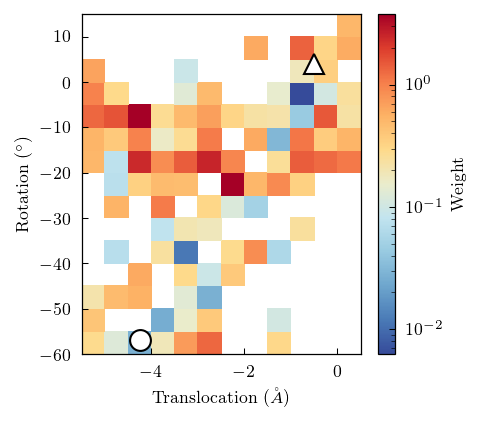

In [217]:
f = plt.figure()
plt.pcolor(
    xeh, yeh, np.reshape(ans3_bin.T, (12, 15)).T, cmap=cm_div, norm=mpl.colors.LogNorm()
)
cb = plt.colorbar(label="Weight")
plotting.format_cvs(f.gca())
plt.xlim([-5.5, 0.5])
plt.ylim([-60, 15])

# Bin committor for PMF

In [19]:
qp_all = np.load("../../data/feat2_dist_du_suppl_2/q_downup.npy", allow_pickle=True)

In [23]:
w_all = np.load("../../data/com_feat2_ivac_suppl_02.npy", allow_pickle=True)

In [20]:
len(qp_all), qp_all[0].shape, qp_all[0][0].shape

(6, (480,), (10000,))

In [24]:
len(w_all), w_all[0].shape, w_all[0][0].shape

(10, (480,), (10000,))

/tmp/jobs/16722880/ipykernel_71577/141319512.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/141319512.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/141319512.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset


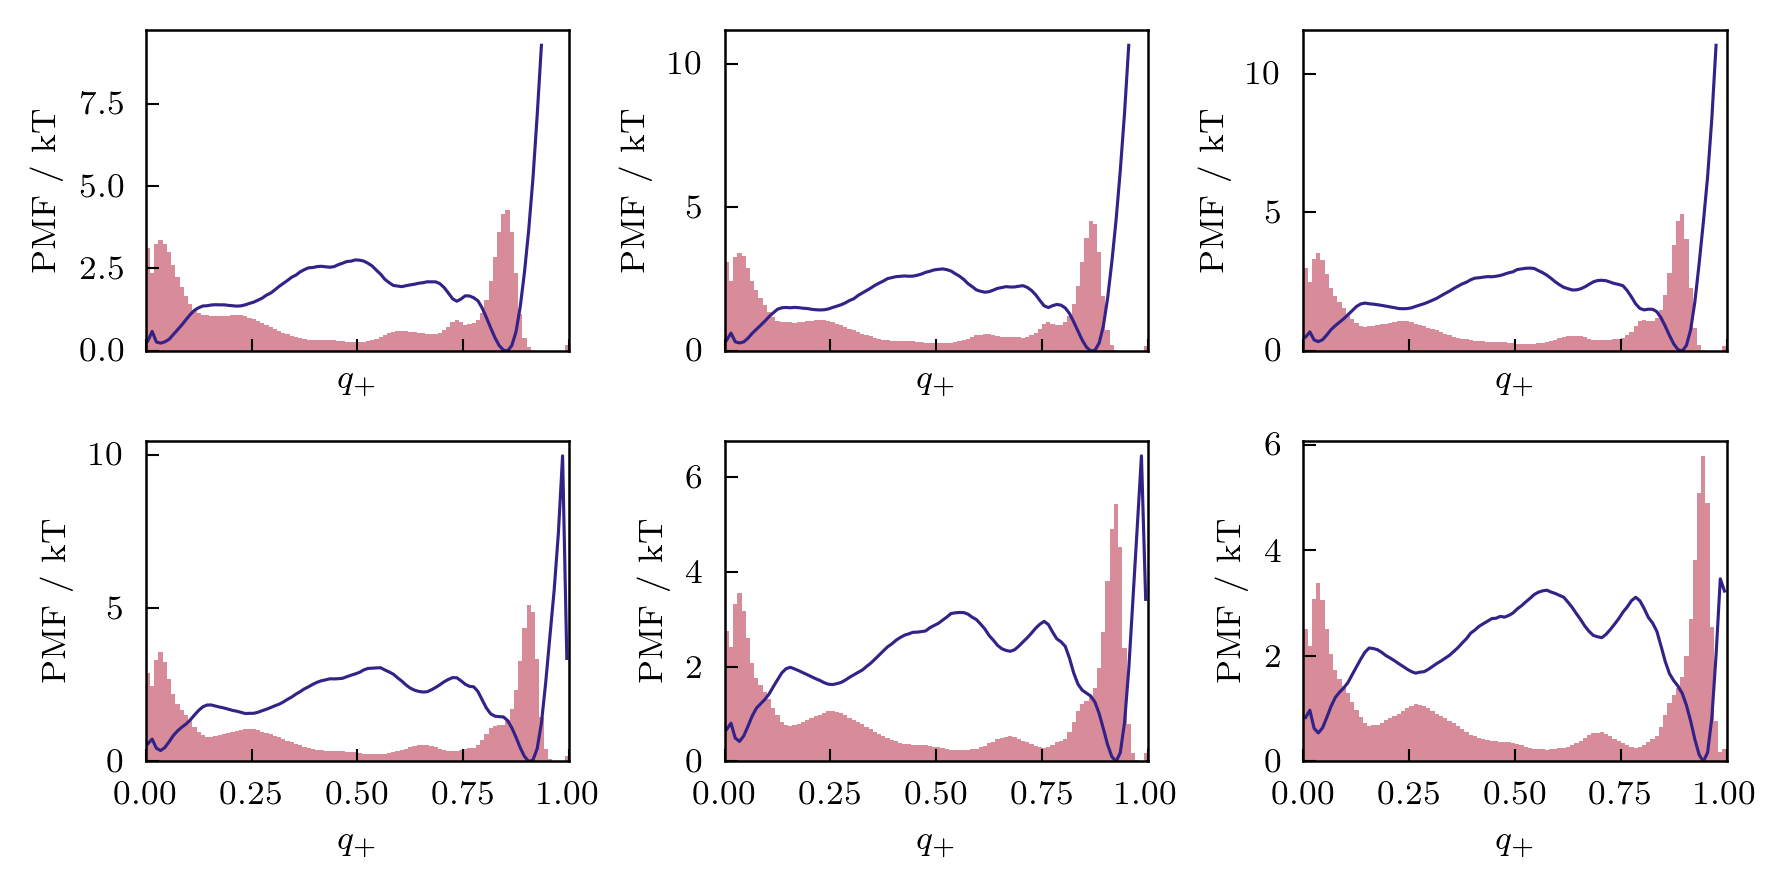

In [30]:
f, axs = plt.subplots(2, 3, figsize=(6, 3), dpi=300, sharex=True)
for ax, q, w in zip(axs.flat, qp_all, w_all):
    q_arr = np.concatenate(q).clip(min=0, max=1)
    w_arr = np.concatenate(w)
    hist, xe = np.histogram(q_arr, bins=100, weights=w_arr, density=True)
    offset = np.min(-np.log(hist[np.nonzero(hist)]))
    diff = -np.log(hist) - offset
    ax.hist(q_arr, weights=w_arr, density=True, bins=100, alpha=0.75)
    ax.plot((xe[1:] + xe[:-1]) / 2, diff)
    ax.set_xlim([0, 1])
    ax.set_xlabel("$q_+$")
    ax.set_ylabel("PMF / kT")
# for ax in axs.flat:
#     ax.label_outer()
f.tight_layout()

In [31]:
qp_ind = np.load("../../data/feat2_ivac_ind1000_suppl/q_downup.npy", allow_pickle=True)

In [32]:
len(qp_ind), qp_ind[0].shape, qp_ind[0][0].shape

(10, (480,), (10000,))

/tmp/jobs/16722880/ipykernel_71577/350843967.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/350843967.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/350843967.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/350843967.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/350843967.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset
/tmp/jobs/16722880/ipykernel_71577/350843967.py:8: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(hist) - offset


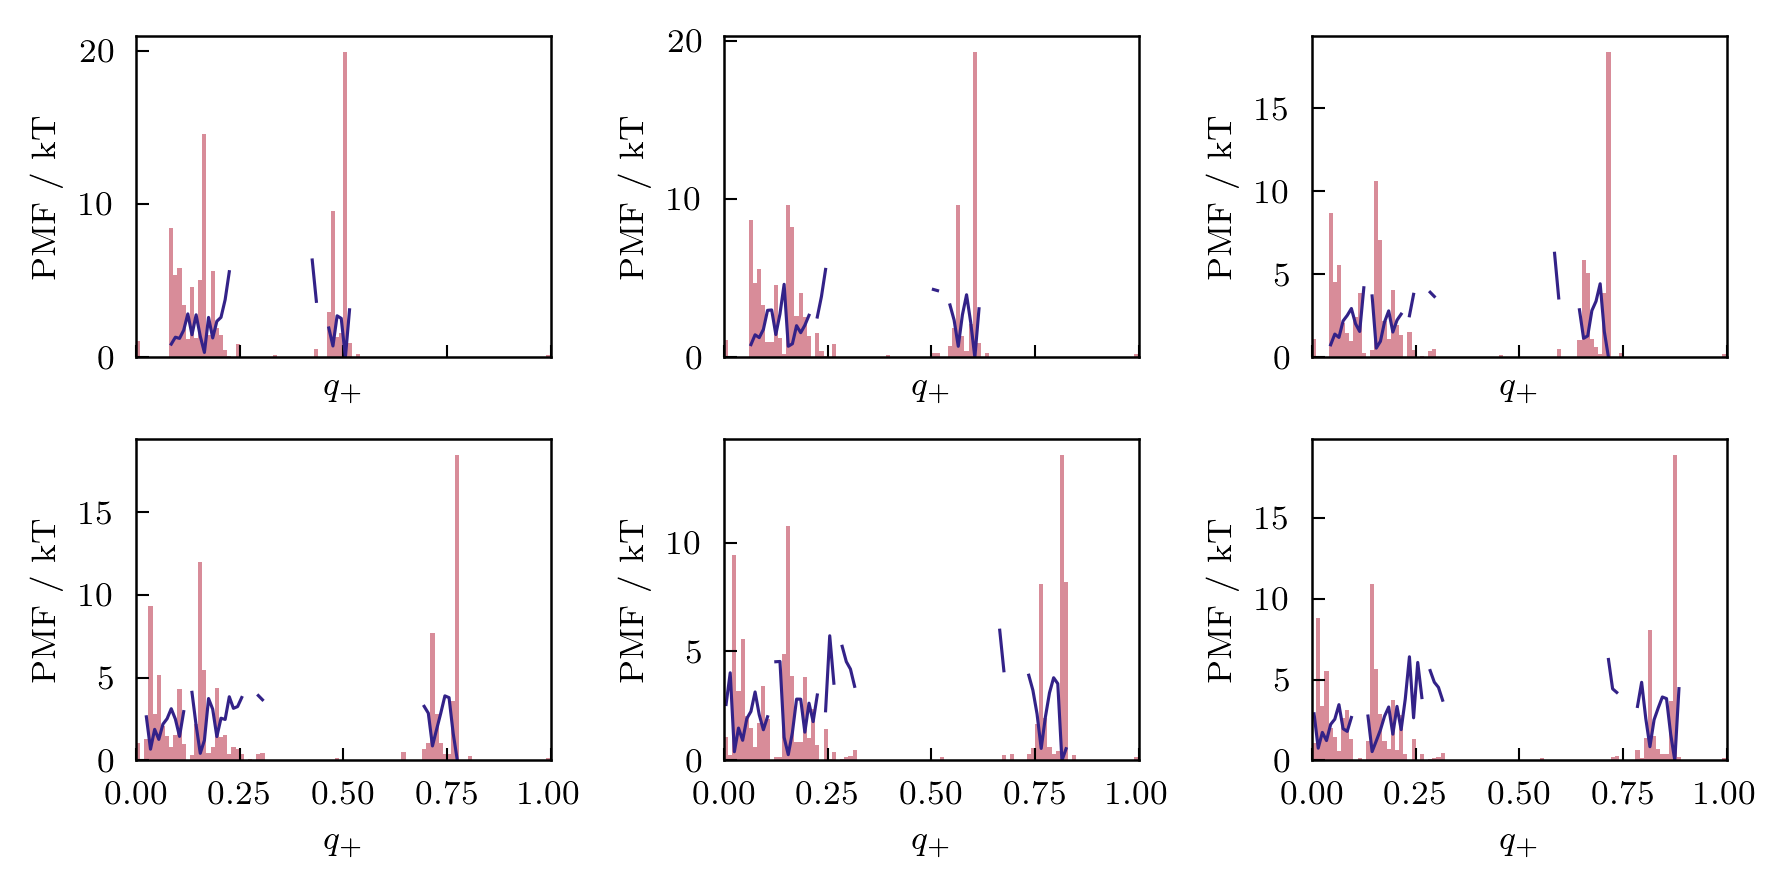

In [33]:
f, axs = plt.subplots(2, 3, figsize=(6, 3), dpi=300, sharex=True)
for ax, q, w in zip(axs.flat, qp_ind, w_all):
    q_arr = np.concatenate(q).clip(min=0, max=1)
    w_arr = np.concatenate(w)
    hist, xe = np.histogram(q_arr, bins=100, weights=w_arr, density=True)
    offset = np.min(-np.log(hist[np.nonzero(hist)]))
    diff = -np.log(hist) - offset
    ax.hist(q_arr, weights=w_arr, density=True, bins=100, alpha=0.75)
    ax.plot((xe[1:] + xe[:-1]) / 2, diff)
    ax.set_xlim([0, 1])
    ax.set_xlabel("$q_+$")
    ax.set_ylabel("PMF / kT")
# for ax in axs.flat:
#     ax.label_outer()
f.tight_layout()

In [39]:
qp_old = np.load("../../data/feat3_dist_anton/100/q_downup.npy", allow_pickle=True)

In [40]:
w_old = np.load("../../data/coms_feat5_ind200_anton.npy", allow_pickle=True)

In [41]:
len(qp_old), qp_old[0].shape, qp_old[0][0].shape

(14, (237,), (10000,))

In [42]:
len(w_old), w_old[0].shape, w_old[0][0].shape

(14, (237,), (10000,))

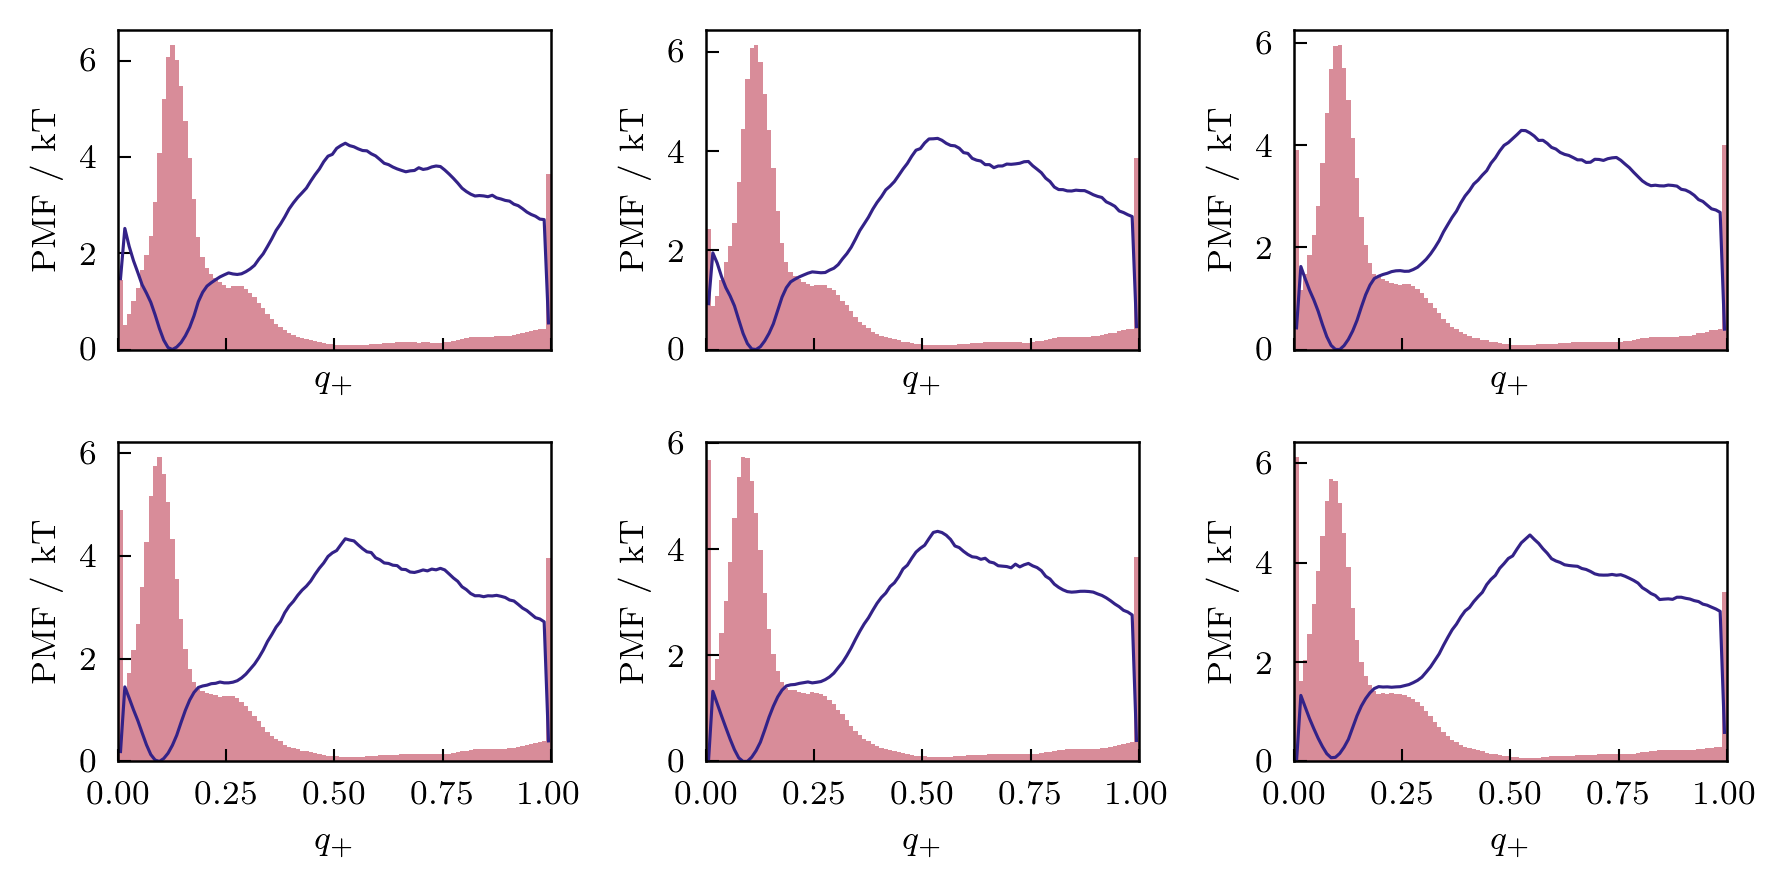

In [43]:
f, axs = plt.subplots(2, 3, figsize=(6, 3), dpi=300, sharex=True)
for ax, q, w in zip(axs.flat, qp_old, w_old):
    q_arr = np.concatenate(q).clip(min=0, max=1)
    w_arr = np.concatenate(w)
    hist, xe = np.histogram(q_arr, bins=100, weights=w_arr, density=True)
    offset = np.min(-np.log(hist[np.nonzero(hist)]))
    diff = -np.log(hist) - offset
    ax.hist(q_arr, weights=w_arr, density=True, bins=100, alpha=0.75)
    ax.plot((xe[1:] + xe[:-1]) / 2, diff)
    ax.set_xlim([0, 1])
    ax.set_xlabel("$q_+$")
    ax.set_ylabel("PMF / kT")
# for ax in axs.flat:
#     ax.label_outer()
f.tight_layout()

In [45]:
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)
zlim = np.linspace(0, 1, 50)
hist = extq.projection.density3d(
    dist_trajs, rot_trajs, qp_all[5], w_all[0], xlim, ylim, zlim
)

In [46]:
hist.shape

(49, 49, 49)

In [53]:
hist.min(), hist.argmin(axis=-1)

(0.0,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))